# Proximal solvers - convergence analysis

We consider a denoising problem and we try to enforce blockyness in our solution)

$$
\mathbf{x} = arg min_\mathbf{x} \frac{\sigma}{2} ||\mathbf{x} - \mathbf{y} ||_2^2 + ||\mathbf{D} \mathbf{x}||_1
$$

and compare the converge behaviour of ADMM and PD.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

In [2]:
def callback(x):
    xinv_hist.append(x)

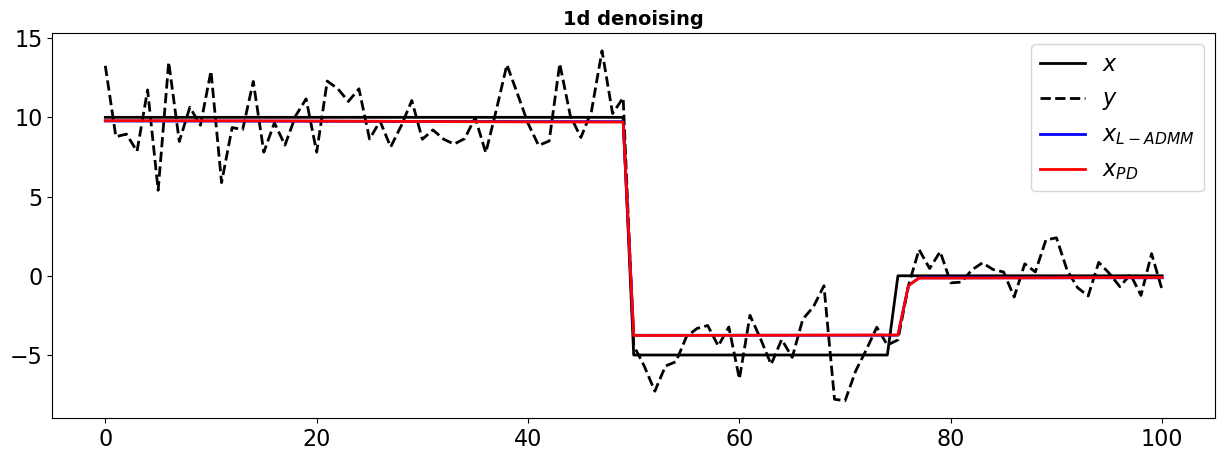

In [3]:
np.random.seed(1)

nx = 101
x = np.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5
n = np.random.normal(0, 2, nx)
y = x + n

l2 = L2(b=y)
Dop = FirstDerivative(nx, edge=True, kind='backward')
l1 = L1(sigma=10.)
niter = 400

# L-ADMM
L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1
mu = 0.99 * tau / L # optimal mu<=tau/maxeig(Dop^H Dop)

xinv_hist = []
xladmm, zladmm = LinearizedADMM(l2, l1, Dop, tau=tau, mu=mu, x0=np.zeros_like(x), niter=niter, callback=callback)
xladmm_hist = xinv_hist

# Primal-dual
L = np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1. / np.sqrt(L)
mu = .99 / (tau * L)

xinv_hist = []
xpd = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=1., 
                 x0=np.zeros_like(x), niter=niter, callback=callback)
xpd_hist = xinv_hist

# Optimal solution
xopt = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=1., 
                  x0=np.zeros_like(x), niter=1000)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x, 'k', lw=2, label=r'$x$')
ax.plot(y, '--k', lw=2, label=r'$y$')
ax.plot(xladmm, 'b', lw=2, label=r'$x_{L-ADMM}$')
ax.plot(xpd, 'r', lw=2, label=r'$x_{PD}$')
ax.set_title('1d denoising', fontsize=14, fontweight='bold')
ax.legend();

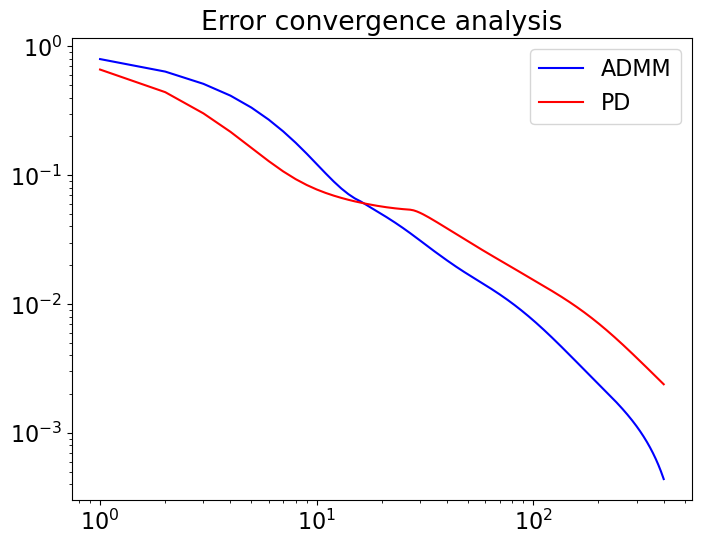

In [5]:
error_ladmm = np.array([np.linalg.norm(xopt - xladmm) / np.linalg.norm(xopt) for xladmm in xladmm_hist])
errora_pd = np.array([np.linalg.norm(xopt - xpd) / np.linalg.norm(xopt) for xpd in xpd_hist])

plt.figure()
plt.loglog(np.arange(1, niter + 1), error_ladmm, 'b', label='ADMM')
plt.loglog(np.arange(1, niter + 1), errora_pd, 'r', label='PD')
plt.title('Error convergence analysis')
plt.legend();

Try http://cvxopt.org for the ground-truth solution (xopt)